In [ ]:
# Importing required Libraries
%reset
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # for gradient descent
import torchvision 
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # for plotting
import os

torch.manual_seed(1) # set random seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
################################################################
# Uploading duration dataset for CNN #1
################################################################

!unzip '/content/drive/MyDrive/OMR/Notes.zip' -d '/root/note_duration'

In [ ]:
%reset

In [ ]:
classes = ['Eight', 'Half', 'Quarter', 'Sixteenth', 'Whole']

data_transform_2 = transforms.Compose([transforms.Resize(size=(28, 28)), 
                                      transforms.ToTensor()])
complete_duration_dataset = datasets.ImageFolder('/root/note_duration/Notes', transform = data_transform_2)

print('Num training images: ', len(complete_duration_dataset))

In [ ]:
# Dataset split - 60%, 30%, 10%

data_train_square, data_val_square, data_test_square = torch.utils.data.random_split(complete_duration_dataset, [3000, 1500, 500])

In [ ]:
training_data_loader = torch.utils.data.DataLoader(data_train_square,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

validation_data_loader = torch.utils.data.DataLoader(data_val_square,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

test_data_loader = torch.utils.data.DataLoader(data_test_square,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=1)

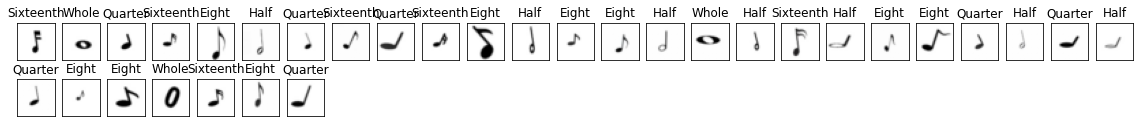

In [ ]:
# Visualize some training data

# obtain one batch of training images
dataiter = iter(training_data_loader)
images_train_2, labels_train_2 = dataiter.next()
images_train_2 = images_train_2.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 5))
for idx in np.arange(32):
    ax = fig.add_subplot(5, 25, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_train_2[idx], (1, 2, 0)))
    ax.set_title(classes[labels_train_2[idx]])

In [ ]:
#-------------------------------------------------------------------------------
# Convolutional Neural Network Architecture
#-------------------------------------------------------------------------------

class MusicSignClassifier(nn.Module):
    def __init__(self):
        super(MusicSignClassifier, self).__init__()
        self.name = "Music_Classifier"
        #self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size (size of 1st layer)
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size (size of 1st layer)
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels (has to be the same as out_chanels from conv1 above!!!), out_chanels (arbitrary, we decide), kernel_size (can choose anything here again)
        
        self.fc1 = nn.Linear(160, 32)

        #5 = num of possible classes in CNN (note durations)
        self.fc2 = nn.Linear(32, 5)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        
        x = x.view(-1, 160) 
       
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# Note: There are 2 Convolution Layers used to help identify features accurately, 2 Max Pooling Layers, 2 Fully-Connected Layers, 
# and the Activation Function chosen was ReLu (as it does not activate all the neurons at the same time).  The 2 convolutional 
# layers are used to learn about the features from the images, while the 2 fully-connected layers are used to classify these 
# image features. The max pooling layers are utilized to summarises the features present in each convolution layer.

In [ ]:
def get_accuracy_2(model, train=False):
    if train==True:
        a = training_data_loader
    else:
        a = validation_data_loader

    correct = 0
    total = 0
    for imgs, labels in iter(a): #torch.utils.data.DataLoader(data, batch_size=64):
       #############################################
       # To Enable GPU Usage
       if use_cuda and torch.cuda.is_available():
         imgs = imgs.cuda()
         labels = labels.cuda()
       #############################################

       output = model(imgs)
       # select index with maximum prediction score
       pred = output.max(1, keepdim=True)[1]
       correct += pred.eq(labels.view_as(pred)).sum().item()
       total += imgs.shape[0]
    return correct / total

In [ ]:
def train_note_duration_2(model, data, batch_size=64, num_epochs=5):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    #val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    #train_loader = train_loader[:1000]
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []
    epochs = []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(training_data_loader):

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss))             # compute *average* loss
            n += 1
        epochs.append(epoch)    
        t_acc = get_accuracy_2(model, train=True)
        train_acc.append(t_acc) # compute training accuracy 
        v_acc = get_accuracy_2(model, train=False)
        val_acc.append(v_acc)  # compute validation accuracy
        print("Epoch %d: Train_acc %f: Val_acc %f" % ((epoch+1), t_acc, v_acc))
      

    end_time= time.time()

    
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    print("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Epoch 1: Train_acc 0.458667: Val_acc 0.432667
Epoch 2: Train_acc 0.625667: Val_acc 0.641333
Epoch 3: Train_acc 0.734000: Val_acc 0.751333
Epoch 4: Train_acc 0.818667: Val_acc 0.835333
Epoch 5: Train_acc 0.825667: Val_acc 0.814000
Epoch 6: Train_acc 0.871000: Val_acc 0.871333
Epoch 7: Train_acc 0.936000: Val_acc 0.934667
Epoch 8: Train_acc 0.933000: Val_acc 0.925333
Epoch 9: Train_acc 0.966333: Val_acc 0.946667
Epoch 10: Train_acc 0.972000: Val_acc 0.966000


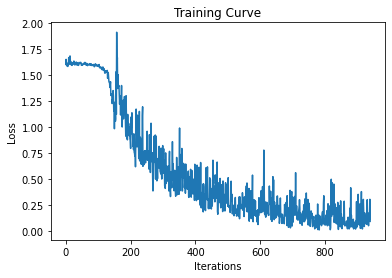

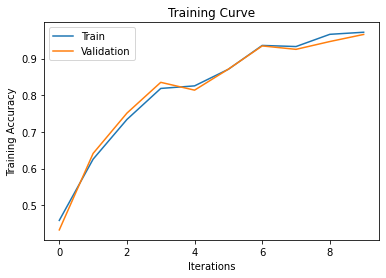

Final Training Accuracy: 0.972
Final Validation Accuracy: 0.966
Total time:   42.41 s  Time per Epoch:   4.24 s 


In [ ]:
use_cuda = True

model = MusicSignClassifier()

#train_note_duration(model, eigth_notes, batch_size=64, num_epochs=5)
train_note_duration_2(model, training_data_loader, num_epochs=10)

Epoch 1: Train_acc 0.446000: Val_acc 0.434000
Epoch 2: Train_acc 0.737000: Val_acc 0.729333
Epoch 3: Train_acc 0.863667: Val_acc 0.852000
Epoch 4: Train_acc 0.898000: Val_acc 0.894000
Epoch 5: Train_acc 0.937667: Val_acc 0.935333
Epoch 6: Train_acc 0.812000: Val_acc 0.808000
Epoch 7: Train_acc 0.930000: Val_acc 0.912667
Epoch 8: Train_acc 0.979000: Val_acc 0.961333
Epoch 9: Train_acc 0.965000: Val_acc 0.948000
Epoch 10: Train_acc 0.984667: Val_acc 0.974667
Epoch 11: Train_acc 0.961333: Val_acc 0.951333
Epoch 12: Train_acc 0.980667: Val_acc 0.970667
Epoch 13: Train_acc 0.996333: Val_acc 0.987333
Epoch 14: Train_acc 0.992333: Val_acc 0.979333
Epoch 15: Train_acc 0.993667: Val_acc 0.981333
Epoch 16: Train_acc 0.993667: Val_acc 0.983333
Epoch 17: Train_acc 0.997000: Val_acc 0.983333
Epoch 18: Train_acc 0.999000: Val_acc 0.990000
Epoch 19: Train_acc 0.999667: Val_acc 0.988667
Epoch 20: Train_acc 0.999667: Val_acc 0.990000
Epoch 21: Train_acc 1.000000: Val_acc 0.988667
Epoch 22: Train_acc 1.

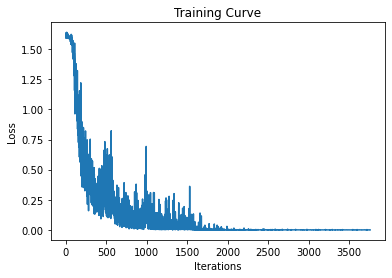

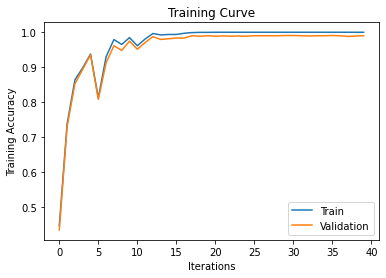

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.99
Total time:   170.09 s  Time per Epoch:   4.25 s 


In [ ]:
use_cuda = True

model = MusicSignClassifier()

#train_note_duration(model, eigth_notes, batch_size=64, num_epochs=5)
train_note_duration_2(model, training_data_loader, num_epochs=40)

In [ ]:
dataiter_test = iter(test_data_loader)
images_test, labels_test = dataiter_test.next()

out = torch.sigmoid(model( images_test[0].unsqueeze(0) )) #input_test.unsqueeze(0)
pred = out.max(1, keepdim=True)[1]
predicted_class = classes[pred]

print(predicted_class)

In [ ]:
images_test_first_image = images_test[0].numpy()
plt.imshow(np.transpose(images_test_first_image, (1, 2, 0)))
print("Model predicted: ", predicted_class)
print("Actual classification: ", classes[labels_test[0]])

In [ ]:
predictions = []
images_test, labels_test = dataiter_test.next()

for i in range(0, 32):

  out = torch.sigmoid(model( images_test[i].unsqueeze(0) )) #input_test.unsqueeze(0)
  pred = out.max(1, keepdim=True)[1]
  predicted_class = classes[pred]
  predictions.append(predicted_class)


images_test = images_test.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(40, 35))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images_test[idx], (1, 2, 0)))

    pred = predictions[idx]
    actual_class = classes[labels_test[idx]]
    if pred != actual_class:
      correct_pred = "WRONG"
    else:
      correct_pred = "CORRECT"
    plot_title = "Pred: " + pred + "\n" + "Act: " + actual_class + "\nModel prediction: " + correct_pred

    ax.set_title(plot_title)